In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile
!pip install kaggle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
# Upload kaggle API file (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiteshbhatnagar","key":"e201a58ba519471d1d6c10af03d3d68e"}'}

In [4]:
# Move kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Downloading the dataset
!kaggle datasets download -d adibadea/chbmitseizuredataset

Dataset URL: https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset
License(s): GNU Affero General Public License 3.0
 96% 609M/635M [00:04<00:00, 122MB/s]
100% 635M/635M [00:05<00:00, 133MB/s]


In [6]:
os.listdir()

['.config', 'chbmitseizuredataset.zip', 'kaggle.json', 'sample_data']

In [7]:
# create a folder datasets
!mkdir -p /content/datasets

# unzip dataset file into datasets directory
!unzip -q /content/chbmitseizuredataset.zip -d /content/datasets

In [8]:
os.listdir('/content')

['.config',
 'chbmitseizuredataset.zip',
 'datasets',
 'kaggle.json',
 'sample_data']

In [9]:
os.listdir('/content/datasets')

['eeg-predictive_val_balanced.npz',
 'eeg-seizure_val_balanced.npz',
 'eeg-seizure_train.npz',
 'eeg-predictive_val.npz',
 'eeg-seizure_val.npz',
 'eeg-predictive_train.npz',
 'eeg-seizure_test.npz']

In [10]:
# Load the data from .npz files

train_data = np.load('/content/datasets/eeg-seizure_train.npz')
val_data = np.load('/content/datasets/eeg-seizure_val_balanced.npz')
test_data = np.load('/content/datasets/eeg-seizure_test.npz')


In [11]:
print(train_data.files)
print(val_data.files)
print(test_data.files)

['train_signals', 'train_labels']
['val_signals', 'val_labels']
['test_signals']


In [12]:
# Extract EEG signals and labels

X_train = train_data['train_signals']
y_train = train_data['train_labels']
X_val = val_data['val_signals']
y_val = val_data['val_labels']
X_test = test_data['test_signals']

In [13]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)


In [14]:
print (X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(37666, 23, 256)
(37666,)
(3546, 23, 256)
(3546,)
(8072, 23, 256)


In [15]:
# Normalization of the input data

X_train = tf.image.per_image_standardization(X_train)
X_val = tf.image.per_image_standardization(X_val)
X_test = tf.image.per_image_standardization(X_test)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(37666, 23, 256)
(3546, 23, 256)
(8072, 23, 256)


In [17]:
# Reshape for CNN input (num_samples/batch_size, height, width, channels)

# -1 in the shape argument allows TensorFlow to automatically infer the size of that dimension based on the total number of elements in the tensor and the other specified dimensions.
# 23 corresponds to the number of channels or features
# 256 number of time steps or sequence length
# 1 indicates that there is only one channel. like if the data has multiple channels per feature like (RGB or RGBA images) then adjust the number
X_train_cnn = tf.reshape(X_train, [-1, 23, 256, 1])
X_val_cnn = tf.reshape(X_val, [-1, 23, 256, 1])
X_test_cnn = tf.reshape(X_test, [-1, 23, 256, 1])

print(X_train_cnn.shape)
print(X_val_cnn.shape)
print(X_test_cnn.shape)

(37666, 23, 256, 1)
(3546, 23, 256, 1)
(8072, 23, 256, 1)


In [18]:
# Data augmentation generator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    zoom_range=0.2,
    rescale=1./255


)
datagen.fit(X_train_cnn)

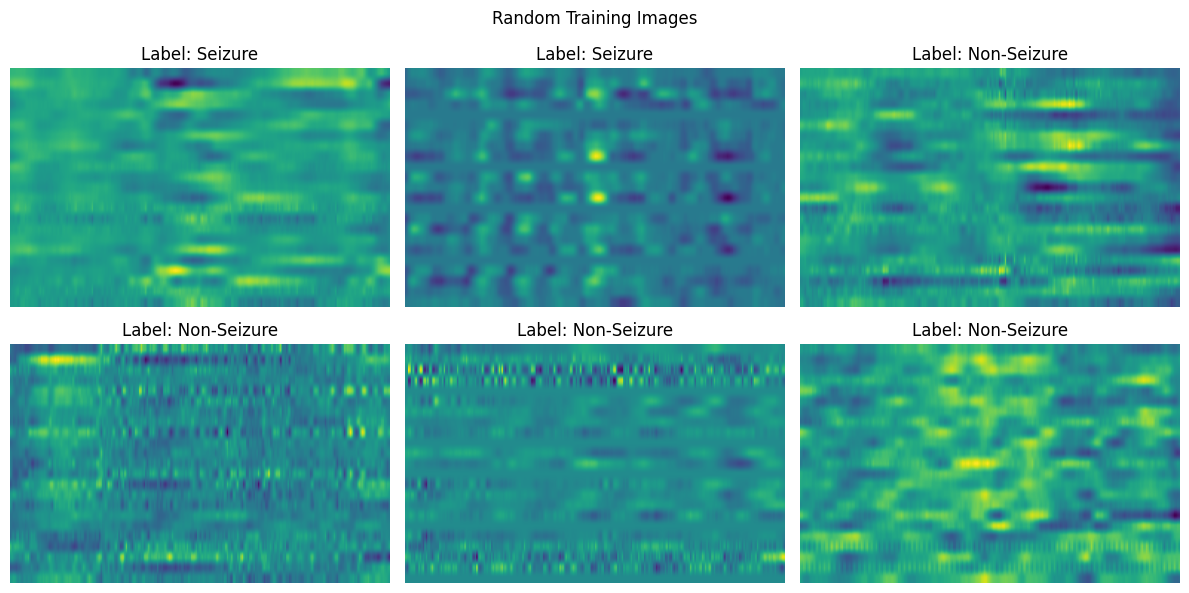

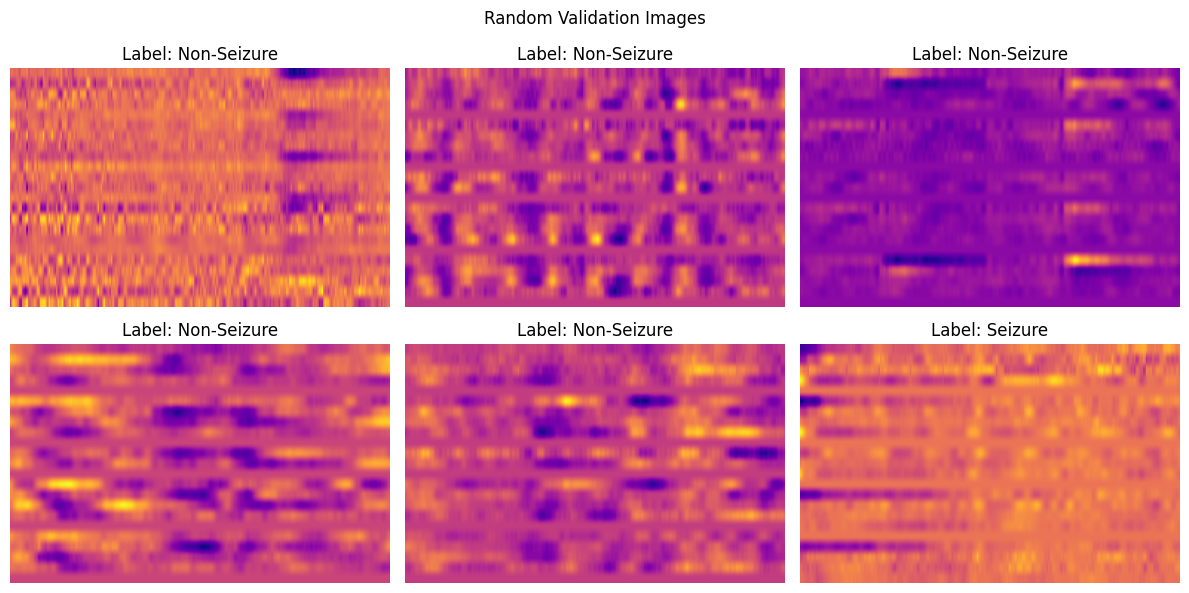

In [19]:
import seaborn as sns

# Generate random images and plots from test_data , val_data and test_data

def plot_random_images(data, labels, title, cmap='viridis'):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        index = np.random.randint(0, len(data))
        plt.subplot(2, 3, i + 1)
        plt.imshow(data[index].numpy().reshape(23, 256), cmap=cmap, aspect='auto')
        plt.title(f'Label: {"Seizure" if labels[index] else "Non-Seizure"}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display random images from training, validation, and test sets with different color maps
plot_random_images(X_train_cnn, y_train, 'Random Training Images', cmap='viridis')
plot_random_images(X_val_cnn, y_val, 'Random Validation Images', cmap='plasma')



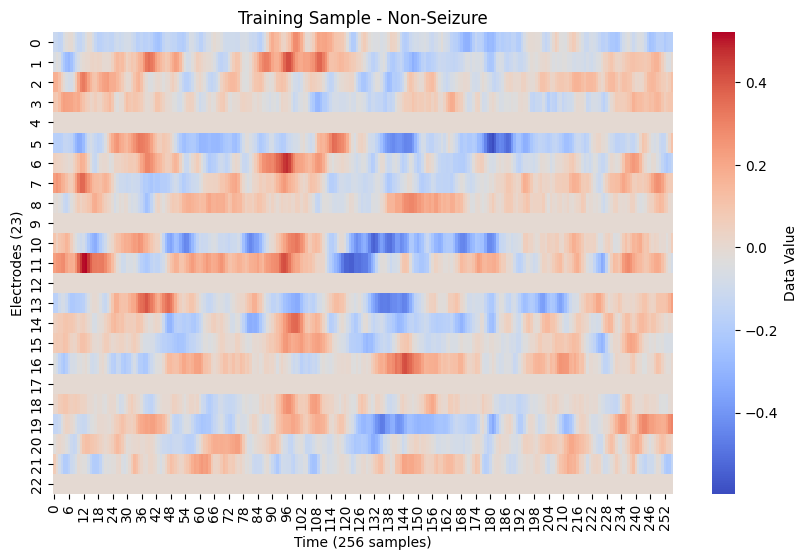

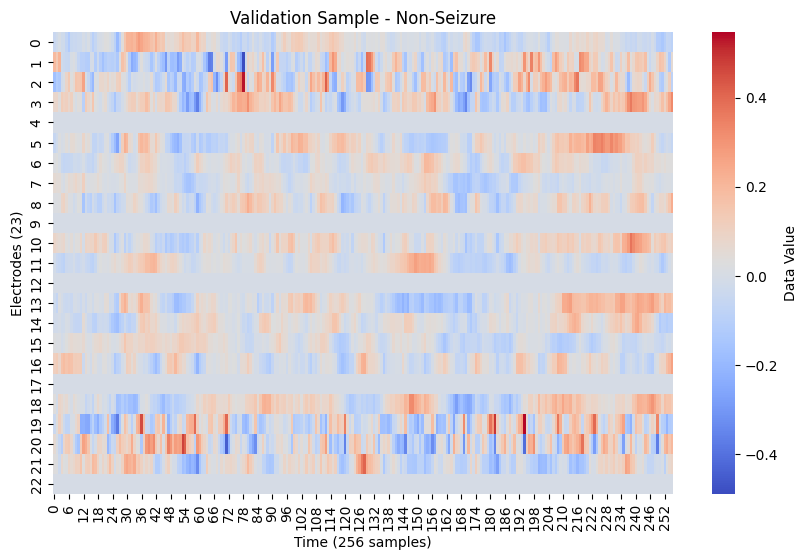

In [20]:
def plot_heatmap(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()  # Convert the tensor to a numpy array
    df = pd.DataFrame(data[index].numpy().reshape(23, 256))
    sns.heatmap(df, cmap='coolwarm', cbar=True, cbar_kws={'label': 'Data Value'})
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (256 samples)')
    plt.ylabel('Electrodes (23)')
    plt.show()

# Plot heatmap for random samples from training, validation, and test sets
plot_heatmap(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_heatmap(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')

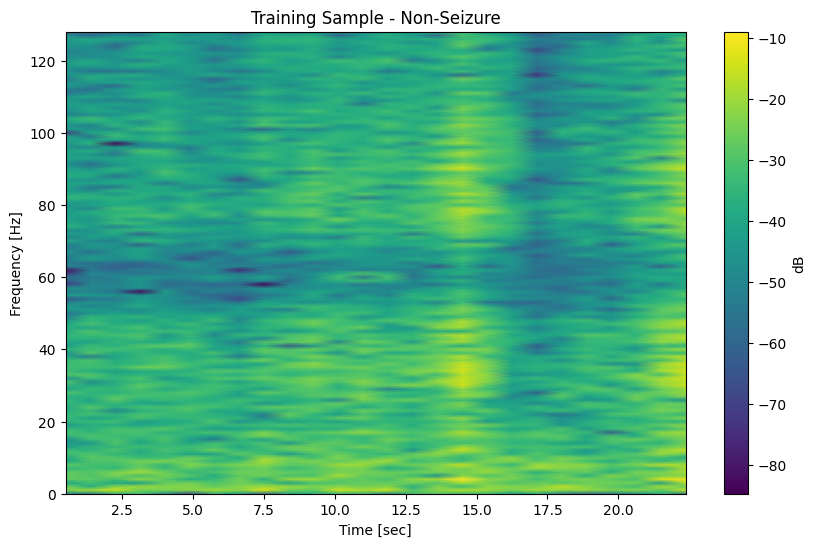

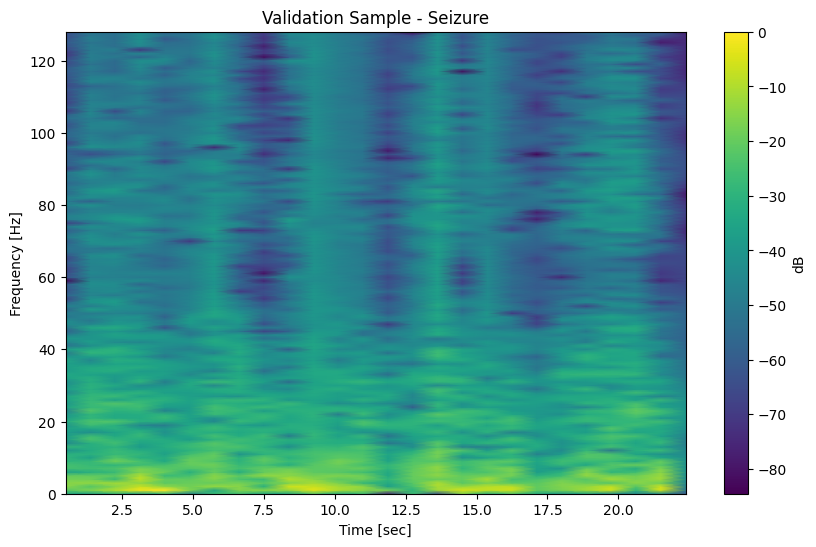

In [21]:
from scipy.signal import spectrogram

# Function to plot spectrogram
def plot_spectrogram(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    f, t, Sxx = spectrogram(data[index].numpy().flatten(), fs=256)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='dB')
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


# Plot spectrogram for random samples from training and validation sets
plot_spectrogram(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_spectrogram(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')




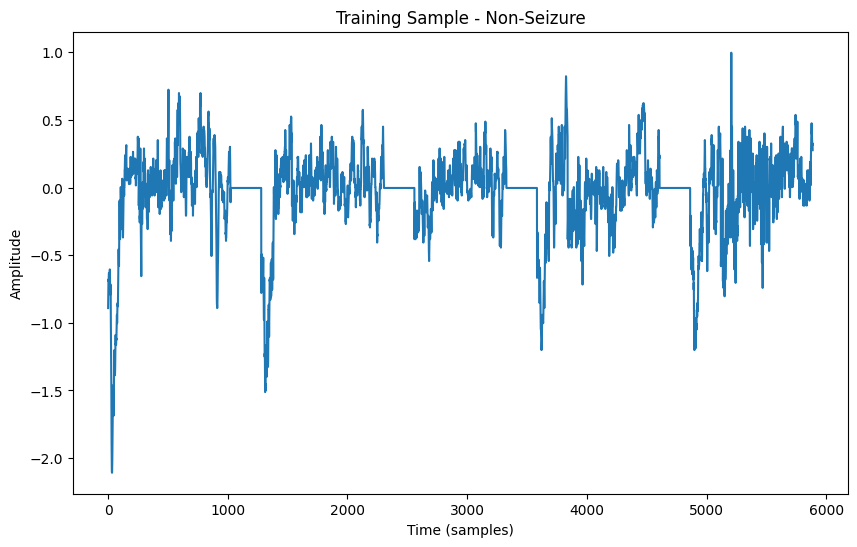

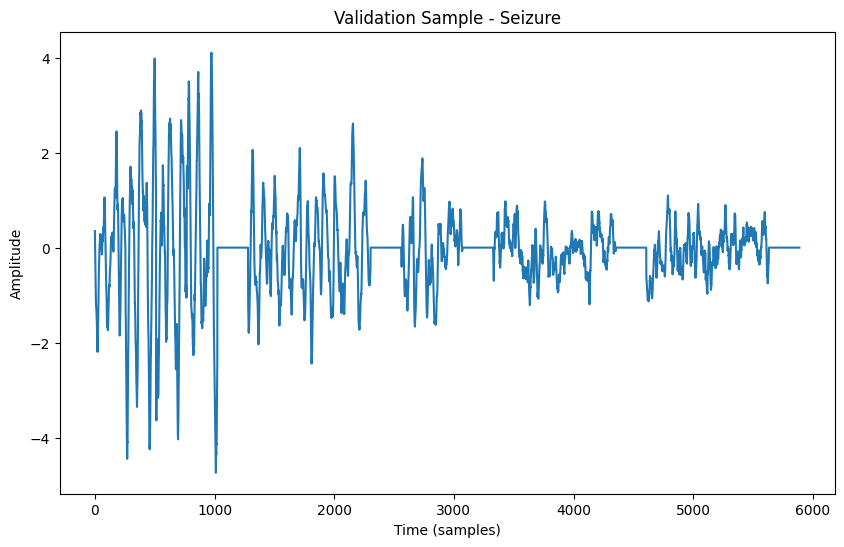

In [22]:
# Function to plot time-series data
def plot_time_series(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    plt.plot(data[index].numpy().flatten())
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

# Plot time-series data for random samples from training and validation sets
plot_time_series(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_time_series(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')

In [23]:
# Optimizing/finding best Hyperparameters using Keras-Tuner

!pip install keras-tuner
from tensorflow import keras
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers, regularizers

# Baseline model

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the baseline model
baseline_model_history = baseline_model.fit(datagen.flow(X_train_cnn, y_train, batch_size=32),
                                    epochs=20,
                                    validation_data=(X_val_cnn, y_val))

# Evalute the baseline_model

baseline_loss , baseline_accuracy = baseline_model.evaluate(X_val_cnn, y_val)
print(f'Baseline Validation Accuracy {baseline_accuracy * 100:.2f}%')

# Generating classification report and confusion matrix for baseline model

baseline_y_pred = (baseline_model.predict(X_val_cnn) > 0.5).astype("int32")
print("Baseline model classification report:")
print(classification_report(y_val, baseline_y_pred))

print("Baseline model confusion matrix:")

print(confusion_matrix(y_val, baseline_y_pred))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00
Epoch 1/20
1178/1178 [==============================] - 39s 32ms/step - loss: 0.4840 - accuracy: 0.8063 - val_loss: 87.7610 - val_accuracy: 0.5000
Epoch 2/20
1178/1178 [==============================] - 37s 32ms/step - loss: 0.4706 - accuracy: 0.8142 - val_loss: 153.3955 - val_accuracy: 0.4997
Epoch 3/20
1178/1178 [==============================] - 37s 31ms/step - loss: 0.4629 - accuracy: 0.8172 - val_loss: 134.3121 - val_accuracy: 0.4966
Epoch 4/20
1178/1178 [==============================] - 37s 32ms/step - loss: 0.4605 - accuracy: 0.8159 - val_loss: 192.0899 - val_accuracy: 0.5000
Epoch 5/20
1178/1178 [==============================] - 37s 32ms/step - loss: 0.4578 - accuracy: 0.8187 - val_loss: 192.7670 - val_accuracy: 0.5000
Epoch 6/20
1178/1178 [==============================] - 37s 32ms/step - loss: 0.4558 - accuracy: 0.8193 - val_loss: 227.4545 - val_accuracy: 0.5000
Epoch 7/20
1178/1178 [=========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


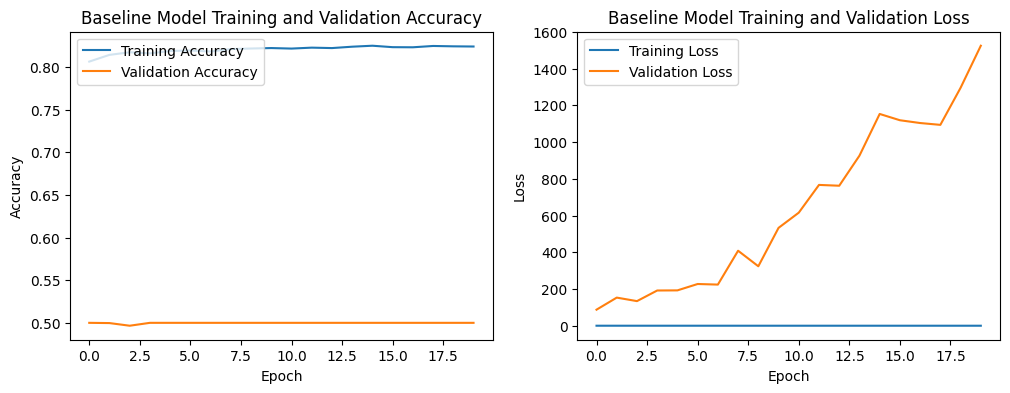

In [24]:
# plot baseline model training and validation accuracy and loss values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(baseline_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(baseline_model_history.history['loss'], label='Training Loss')
plt.plot(baseline_model_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Baseline model summary

In [25]:
print(baseline_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 254, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 127, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 62, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 15872)             0         
                                                                 
 dense (Dense)               (None, 64)                1

##Choosing hyperparameter values :

1. Number of Filter('conv_1_filter','conv_2_filter'):

*   Range: between 32 - 128
*   Reason: Lower values may not capture sufficient features while too high values can lead to overfitting and high computational cost

2. Kernel Size (conv_1_kernel, conv_2_kernel):

*   between 3 - 5
*   Reason: Smaller kernel capture fine details while larger kernels capture more context.

3. Units in Dense Layer ('dense_1_units'):

*   b/w 32 - 128
*   Reason: This controls the complexity of the network. Too few units might underfit, and too many might overfit

4. Optimizer ('optimizer'):

*   'adam','sgd'
*   Reason:Adam is popular for its adaptive learning rate. SGD is simple and effective, often leading to good generalization.







In [26]:
from tensorflow.keras.layers import BatchNormalization

def build_model(hp):
    model = keras.Sequential()

    # First 2d convolution matrix

    model.add(layers.Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(23, 256, 1),
                     kernel_regularizer = regularizers.l2(0.01)

                     ))

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Second Convolution layer

    model.add(layers.Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer = regularizers.l2(0.01)

                     ))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.BatchNormalization())


    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Dense layer

    model.add(layers.Dense(
        units=hp.Int('units', min_value=64, max_value=128, step=64),
        activation='relu'

        ))

    model.add(layers.Dropout(
        rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)
        ))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer= keras.optimizers.Adam(
            learning_rate = hp.Float('learning_rate', min_value= 1e-4, max_value = 1e-2, sampling = 'LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



In [27]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,     # number of different hyperparameter combinations to try
    hyperband_iterations=1,    # number of times to train each model
    directory='hyperparameter_tuning_results',
    project_name='Epileptic_Seizure_Detection'
)


In [28]:
# Searching best hyperparameters on the training and validation data

tuner.search(datagen.flow(X_train_cnn, y_train, batch_size=32), epochs=20, validation_data=(X_val_cnn, y_val))


Trial 30 Complete [00h 09m 58s]
val_accuracy: 0.5087422728538513

Best val_accuracy So Far: 0.632543683052063
Total elapsed time: 02h 25m 31s


In [29]:
 # Retrieveing the best hyperparameters found from the RandomSearch

 best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
 print(best_hps)


In [ ]:
# Build and Train the model with best hyperparameters

model = tuner.hypermodel.build(best_hps)

history = model.fit(datagen.flow(X_train_cnn, y_train, batch_size=32),
                                    epochs=30,
                                    validation_data=(X_val_cnn, y_val))

In [ ]:
# Evaluate the tuned model on validation set

tuned_loss, tuned_accuracy = model.evaluate(X_val_cnn, y_val)
print(f'Tuned Validation Accuracy {tuned_accuracy * 100:.2f}%')

# Generating classification report and confusion matrix for tuned model

tuned_y_pred = (model.predict(X_val_cnn) > 0.5).astype("int32")

print("Best model classification report:")
print(classification_report(y_val, tuned_y_pred))

print("Best model confusion matrix:")

print(confusion_matrix(y_val, tuned_y_pred))



In [ ]:
# plot tuned model training & validation accuracy and loss values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

## Comparing Both the models i.e Baseline model and Tuned Model

In [ ]:
print(f'Baseline Model Validation Accuracy {baseline_accuracy * 100:.2f}%')
print(f'Tuned Model Validation Accuracy {tuned_accuracy * 100:.2f}%')

# plot training & validation accuracy and loss values for both models

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(baseline_model_history.history['val_accuracy'], label='Baseline Model Val Accuracy')

plt.plot(tuned_history.history['val_accuracy'], label='Tuned Model Val Accuracy')

plt.title('Model Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(loc='upper left')


plt.subplot(1,2,2)
plt.plot(baseline_model_history.history['val_loss'], label='Baseline Model Val Loss')
plt.plot(tuned_history.history['val_loss'], label='Tuned Model Val Loss')
plt.title('Model Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(loc='upper left')

plt.show()

## Test the tuned model on random Samples

In [ ]:
def test_random_samples(model, X_val_cnn , y_val , num_samples =5 ):
  indices = np.random.choice(len(X_val_cnn), num_samples, replace=False)
  for i in indices:
    sample = X_val_cnn[i]
    true_label = y_val[i]
    prediction = (model.predict(np.expand_dims(sample, axis=0)) > 0.5).astype("int32")

    print(f'True Label: {"Seizure" if true_label else "Non-Seizure"}, Prediction: {"Seizure" if prediction else "Non-Seizure"}')

test_random_samples(model, X_val_cnn, y_val)